## Synthesis Data

In [1]:
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
x = np.random.normal(0, 1, 1000)
y = np.sin(2*x) + np.random.normal(0, 0.1, 1000)

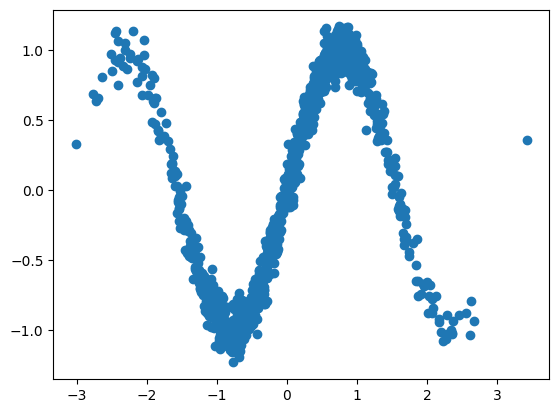

In [3]:
plt.scatter(x, y)
plt.show()

## Simulation with tensorflow

Assuming $$\hat{y}=\beta_0+\beta_1x$$

In [4]:
W1 = tf.Variable(0.0, name = "W1")
W2 = tf.Variable(0.0, name = "W2")
W3 = tf.Variable(0.0, name = "W3")
b = tf.Variable(0.0, name = "b")

In [5]:
lr = 0.001
epochs = 10000

In [6]:
def mse_model(x, y, b0, b1, b2, b3):
    predy = b0 + b1*x + b2*(x**2) + b3*(x**3)
    error = (predy - y)**2

    return tf.reduce_mean(error)

def gradient_lr(x, y, b0, b1, b2, b3):
    with tf.GradientTape() as tape:
        loss = mse_model(x, y, b0, b1, b2, b3)
        
    return tape.gradient(loss, [b3, b2, b1, b0])

In [7]:
for e in range(0, epochs+1):
    db3, db2, db1, db0 = gradient_lr(x, y, b, W1, W2, W3)

    W3.assign_sub(db3*lr)
    W2.assign_sub(db2*lr)
    W1.assign_sub(db1*lr)
    b.assign_sub(db0*lr)

    if e % 1000 == 0:
        loss = mse_model(x, y, b, W1, W2, W3)
        print('Epoch ', e, '; Loss: ',loss)

Epoch  0 ; Loss:  tf.Tensor(0.5191181, shape=(), dtype=float32)
Epoch  1000 ; Loss:  tf.Tensor(0.27773526, shape=(), dtype=float32)
Epoch  2000 ; Loss:  tf.Tensor(0.21942319, shape=(), dtype=float32)
Epoch  3000 ; Loss:  tf.Tensor(0.20481011, shape=(), dtype=float32)
Epoch  4000 ; Loss:  tf.Tensor(0.20114382, shape=(), dtype=float32)
Epoch  5000 ; Loss:  tf.Tensor(0.20022354, shape=(), dtype=float32)
Epoch  6000 ; Loss:  tf.Tensor(0.19999251, shape=(), dtype=float32)
Epoch  7000 ; Loss:  tf.Tensor(0.19993451, shape=(), dtype=float32)
Epoch  8000 ; Loss:  tf.Tensor(0.19991994, shape=(), dtype=float32)
Epoch  9000 ; Loss:  tf.Tensor(0.19991629, shape=(), dtype=float32)
Epoch  10000 ; Loss:  tf.Tensor(0.1999154, shape=(), dtype=float32)


In [8]:
value = tf.get_static_value(W3*(x**3)+W2*(x**2)+W1*x+b)

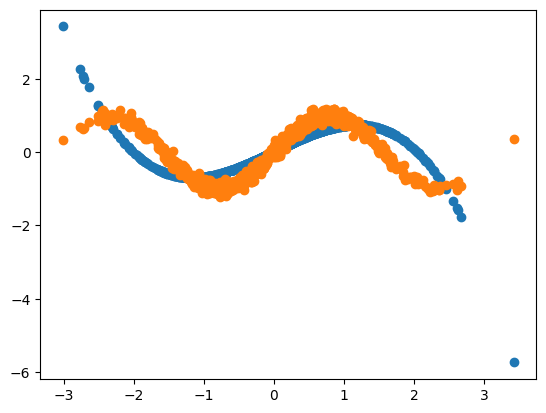

In [9]:
plt.scatter(x, value)
plt.scatter(x, y)

## Basic function

In [2]:
import torch
import math
from torch import nn

In [4]:
class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'

In [3]:
# Fixed Synthesis data
p = torch.tensor([0, 1, 2, 3])
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)
xx = x.unsqueeze(-1).pow(p)
n = len(x)

criterion = torch.nn.MSELoss(reduction='sum')

In [5]:
def loss_fn(output, target, ps, lmda):
    ls = criterion(output, target)
    dm = diag_mat(ps)
    penalty = (lmda/len(target)) * np.sum(np.square(dm @ ps))
    return ls + penalty

In [6]:
def diag_mat(ps):
    dg = np.zeros((len(ps)-1, len(ps)))
    for i in range(len(ps)-1):
        dg[i,i] = -1
        dg[i,i+1]= 1
    return dg

### OLS

In [8]:
modelols = Polynomial3()
optimizer = torch.optim.SGD(modelols.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the modelols
    y_pred = modelols(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {modelols.string()}')

99 1546.0654296875
199 1052.6519775390625
299 718.3929443359375
399 491.7099609375
499 337.8148498535156
599 233.22052001953125
699 162.0537567138672
799 113.57687377929688
899 80.5182876586914
999 57.948158264160156
1099 42.52128601074219
1199 31.96463966369629
1299 24.732450485229492
1399 19.77215003967285
1499 16.36616325378418
1599 14.024779319763184
1699 12.413432121276855
1799 11.303279876708984
1899 10.537609100341797
1999 10.008932113647461
Result: y = 0.03041023761034012 + 0.8381345272064209 x + -0.0052462732419371605 x^2 + -0.09068380296230316 x^3


### SPLINE

In [9]:
modelsp = Polynomial3()
optimizer = torch.optim.SGD(modelsp.parameters(), lr=1e-6)
lambda2 = 0.5

for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the modelsp
    y_pred = modelsp(x)
    
    # parameter space
    param_ls = []
    for param in modelsp.parameters():
        param_ls.append(param.detach().numpy())
    param_ls = np.array(param_ls)

    # Compute and print loss
    loss = loss_fn(y, y_pred, param_ls, lambda2)

    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'Result: {modelsp.string()}')

99 148.23370361328125
199 103.57250213623047
299 73.29133605957031
399 52.73675537109375
499 38.76911163330078
599 29.26698112487793
699 22.795368194580078
799 18.382835388183594
899 15.370779991149902
999 13.312338829040527
1099 11.904003143310547
1199 10.939326286315918
1299 10.277783393859863
1399 9.82362174987793
1499 9.51146411895752
1599 9.29667854309082
1699 9.148715019226074
1799 9.046683311462402
1899 8.976243019104004
1999 8.927565574645996
Result: y = 0.009321670047938824 + 0.8512006402015686 x + -0.001608143444173038 x^2 + -0.09254234284162521 x^3


### Comparison

In [10]:
predols = modelols(x)
predsp = modelsp(x)

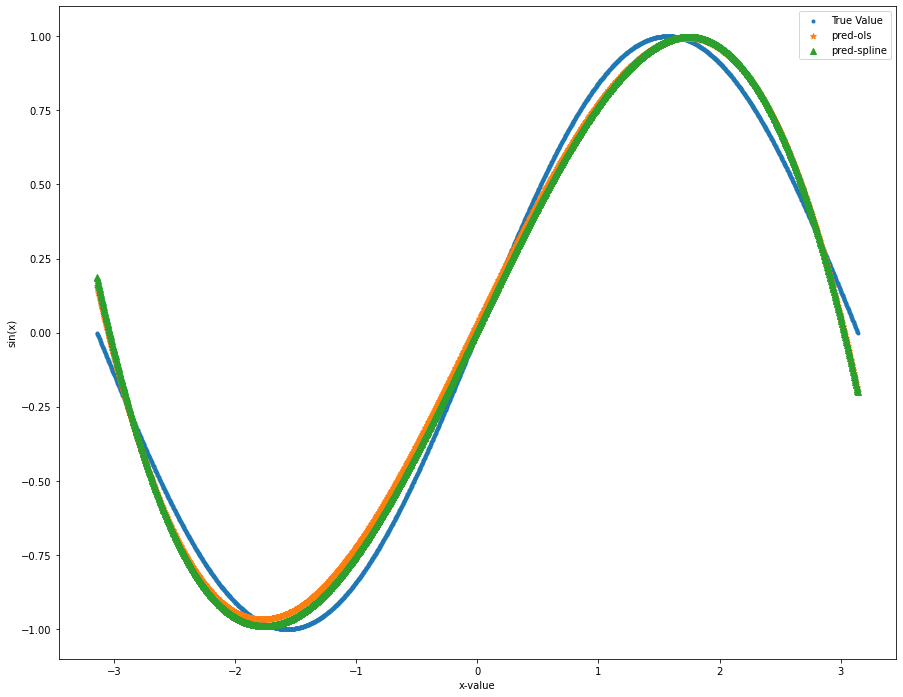

In [11]:
plt.figure(figsize = (15,12))
plt.scatter(x, y, marker = '.', label = 'True Value')
plt.scatter(x, predols.detach().numpy(), marker = '*', label = 'pred-ols')
plt.scatter(x, predsp.detach().numpy(), marker = '^', label = 'pred-spline')

plt.xlabel("x-value")
plt.ylabel("sin(x)")
plt.legend()
plt.show()

## Customized 

In [57]:
class Multilayer(nn.Module):
    def __init__(self, input_sample, output_sample):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu = nn.Sequential(
            nn.Linear(input_sample, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, output_sample),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu(x)
        return logits
    
    

In [17]:
x = torch.reshape(x, (n, 1))

In [98]:
def loss_fn(output, target, ps, lmda):

    output = torch.reshape(output, (len(target),1))
    ls = criterion(output, target)
    penalty = 0 
    for mat in ps:
        dm = diag_mat(mat)
        penalty += (lmda/len(target)) * np.sum(np.square(dm @ mat))

    return ls + penalty

In [104]:
multi_model = Multilayer(input_sample = 1, output_sample = 1)
optimizer = torch.optim.SGD(multi_model.parameters(), lr=1e-5)
lambda2 = 0.5

for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the modelsp
    y_pred = multi_model(x)
    
    # parameter space
    param = list(multi_model.parameters())
    pspace = len(param)
    param_ls = []

    for i in range(pspace-1):
        if i % 2 == 1:
            param_ls.append(param[i].detach().numpy())
    param_ls = np.array(param_ls)

    # Compute and print loss
    loss = loss_fn(y, y_pred, param_ls, lambda2)

    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#print(f'Result: {multi_model.string()}')
print(f'Result: Done')

99 55.83702087402344
199 24.140338897705078
299 14.175814628601074
399 9.17547607421875
499 6.059704780578613
599 4.481112480163574
699 3.525506019592285
799 2.8743975162506104
899 2.408781051635742
999 2.059666156768799
1099 1.788155198097229
1199 1.5704503059387207
1299 1.3916118144989014
1399 1.2418347597122192
1499 1.1145203113555908
1599 1.005295753479004
1699 0.9107181429862976
1799 0.8275277614593506
1899 0.7533794641494751
1999 0.6864861845970154
Result: Done


In [106]:
pred_cus = multi_model(x)

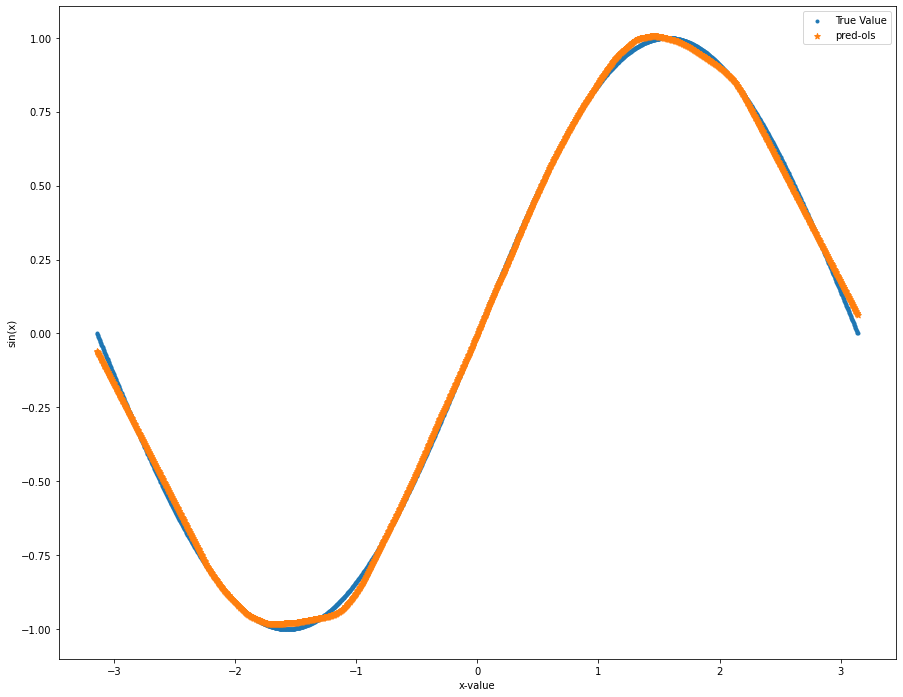

In [107]:
plt.figure(figsize = (15,12))
plt.scatter(x, y, marker = '.', label = 'True Value')
plt.scatter(x, pred_cus.detach().numpy(), marker = '*', label = 'pred-ols')

plt.xlabel("x-value")
plt.ylabel("sin(x)")
plt.legend()
plt.show()